reference:
    
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# 0. Importing Packages

In [16]:
import numpy as np
from numpy import array, hstack
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns


from datetime import datetime, timedelta


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.utils import shuffle

from sklearn import preprocessing

rcParams['figure.figsize'] = 20, 6

In [78]:
from keras.models import load_model
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from keras.optimizers import Adam
from keras.utils import Sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import re


# 1. Loading Data

In [19]:
# Getting all the files in the directory.
def existing_file_list(path):
    ''' Extracting File Names '''

    allFiles = glob.glob(path + "/*.csv")
    new_list = []
    for i in allFiles:
        before = 'original\\'
        after = '_minute'
        ticker = i[i.find(before) + len(before) : i.find(after)]
        new_list.append(ticker)    
    #list_ticker = list(filter(None, text))  # drop all the empty elements and put them in a list
        
    return (new_list)


In [20]:
datapath = 'D:\\OneDrive - Georgia State University\\Data Science\\Personal_Project\\FPL_Analysis\\Data\\Final\\'

from os import listdir
from os.path import isfile, join
main_data_list = [f for f in listdir(datapath) if isfile(join(datapath, f))]

In [21]:
datapath

'D:\\OneDrive - Georgia State University\\Data Science\\Personal_Project\\FPL_Analysis\\Data\\Final\\'

In [23]:
main_data_list

['bootstrap.xlsx',
 'elements.xlsx',
 'element_types.xlsx',
 'merged_gw.csv',
 'next_event_fixtures.xlsx',
 'teams.xlsx',
 '~$bootstrap.xlsx',
 '~$teams.xlsx']

In [29]:
#element_types = pd.read_csv(datapath + 'element_types.xlsx',index_col='id', engine = 'python')
bootstrap = pd.read_excel(datapath + 'bootstrap.xlsx',index_col='id')
main_data = pd.read_csv(datapath + 'merged_gw.csv', index_col=['id', 'fixture'], engine = 'python')
teams = pd.read_excel(datapath + 'teams.xlsx',index_col='id')

by_team =  pd.read_csv(datapath + 'by_team.csv', engine = 'python')
by_position =  pd.read_csv(datapath + 'by_position.csv', engine = 'python')
by_player =  pd.read_csv(datapath + 'by_player.csv', engine = 'python')


In [30]:
main_data.sort_index(inplace=True)
bootstrap.sort_index(inplace=True)
teams.sort_index(inplace=True)

In [31]:
main_data.head()
main_data.tail()


main_data.dtypes

name  assists  attempted_passes  big_chances_created  \
id fixture                                                                
1  1        Petr_Cech_1        0                42                    0   
   14       Petr_Cech_1        0                35                    0   
   21       Petr_Cech_1        0                24                    0   
   33       Petr_Cech_1        0                38                    0   
   46       Petr_Cech_1        0                33                    0   

            big_chances_missed  bonus  bps  clean_sheets  \
id fixture                                                 
1  1                         0      0   24             0   
   14                        0      0   26             0   
   21                        0      0   17             0   
   33                        0      0    8             0   
   46                        0      0   13             0   

            clearances_blocks_interceptions  completed_passes    ...     \
id fixture                                                       ...      
1  1                                      2                31    ...      
   14                                     1                25    ...      
   21                                     0                20    ...      
   33                                     0                24    ...      
   46                                     2                23    ...      

            total_points  transfers_balance  transfers_in  transfers_out  \
id fixture                                                                 
1  1                   3                  0             0              0   
   14                  3                188          6059           5871   
   21                  3               8540         19550          11010   
   33                  1               9582         19332           9750   
   46                  2              -3297          8837          12134   

            value  was_home  winning_goals  yellow_cards  team  position  
id fixture                                                                
1  1           50      True              0             0     1         1  
   14          50     False              0             0     1         1  
   21          50      True              0             0     1         1  
   33          50     False              0             0     1         1  
   46          50     False              0             0     1         1  

[5 rows x 49 columns]

,,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,team,position
id,fixture,,,,,,,,,,,,,,,,,,,,,
620,373,Matt_Butcher_620,0,0,0,0,0,0,0,0,0,...,0,0,0,0,45,False,0,0,2,3
621,374,Luca_De La Torre_621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,45,True,0,0,9,3
622,374,Kelland_Watts_622,0,0,0,0,0,0,0,0,0,...,0,0,0,0,45,False,0,0,15,3
623,374,Lewis_Cass_623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,40,False,0,0,15,2
624,375,Addji Keaninkin Marc-Israel_Guehi_624,0,0,0,0,0,0,0,0,0,...,0,0,0,0,40,False,0,0,6,2


name                                object
assists                              int64
attempted_passes                     int64
big_chances_created                  int64
big_chances_missed                   int64
bonus                                int64
bps                                  int64
clean_sheets                         int64
clearances_blocks_interceptions      int64
completed_passes                     int64
creativity                         float64
dribbles                             int64
errors_leading_to_goal               int64
errors_leading_to_goal_attempt       int64
fouls                                int64
goals_conceded                       int64
goals_scored                         int64
ict_index                          float64
influence                          float64
key_passes                           int64
minutes                              int64
offside                              int64
open_play_crosses                    int64
opponent_te

Let’s understand the arguments one by one:

- parse_dates: This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.
 
- index_col: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.
 
- date_parser: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined. Something similar to the dataparse function defined here can be used for this purpose.

# 2. Preprocessing

In this section, I will prepare the dataset for feeding into LSTM network. Basically, I will do 4 things.

1. Transform data to stationary
2. Transform data to supervised learning
3. Split the data into train and test
4. Scale the data to (-1,1)

# 3) Splitting Data

## 3-1) Prepare Features and Labels  

In [61]:
def create_train_test(data):
    '''Create training and validation features and labels'''
    data = shuffle(data)
    a = round(len(data)*0.7)
    
    train, test = data.iloc[:a], data.iloc[a:]
    
    return train, test

In [62]:
def normalization(data):
    '''normalizing the data'''
    
    scaler = preprocessing.MinMaxScaler()
    if len(data.columns) == 1:
        data = data.values.reshape(-1, 1)
    else:
        pass
    
    scaled = scaler.fit_transform(data)
    #scaled = pd.DataFrame(scaled, columns=data.columns, index = data.index)
    
    return scaled, scaler

In [92]:
main_data = main_data.drop('name', axis=1)

In [122]:
train, test = create_train_test(main_data_)
normalized_train, scaler = normalization(train)
normalized_test, scaler = normalization(test)


D:\Programming\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\Programming\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [123]:
print (f"shape of x_train_reshaped: {normalized_train.shape}, \nshape of y_train: {y_train.shape}, \n\nshape of x_test_reshaped: {x_test_reshaped.shape}, \nshape of y_test: {y_test.shape}")

shape of x_train_reshaped: (15253, 48), 
shape of y_train: (15253,), 

shape of x_test_reshaped: (6537, 1, 47), 
shape of y_test: (6537,)


## 3-2) Reshape features

In [124]:
print (f"shape of x_train_reshaped: {x_train_reshaped.shape}, \nshape of y_train: {y_train.shape}, \n\nshape of x_test_reshaped: {x_test_reshaped.shape}, \nshape of y_test: {y_test.shape}")

shape of x_train_reshaped: (15253, 1, 47), 
shape of y_train: (15253,), 

shape of x_test_reshaped: (6537, 1, 47), 
shape of y_test: (6537,)


# 4) Build and Train a Model

In [125]:
n_timesteps, n_features, n_outputs = x_train_reshaped.shape[1], x_train_reshaped.shape[2], 1

print (f"shape of number of timesteps: {n_timesteps} \nnumber of features: {n_features} \nnumber of outputs: {n_outputs}")

shape of number of timesteps: 1 
number of features: 47 
number of outputs: 1


## 4-1) First Model

In [126]:
'''# Returns a compiled model identical to the previous one
model = load_model('E:\Data Science\Personal_Project\RNN - Solar Farm\model\LSTM_Model.h5')'''

"# Returns a compiled model identical to the previous one\nmodel = load_model('E:\\Data Science\\Personal_Project\\RNN - Solar Farm\\model\\LSTM_Model.h5')"

In [127]:
# define model
model_RNN = Sequential()
model_RNN.add(SimpleRNN(286, activation='sigmoid', input_shape = (n_timesteps, n_features)))
#model_RNN.add(Dropout(0.1))
model_RNN.add(Dense(100, activation='sigmoid'))
#model_RNN.add(Dropout(0.1))
#model_RNN.add(Dense(50, activation='sigmoid'))
model_RNN.add(Dense(n_outputs))

model_RNN.compile(loss='mean_squared_error', optimizer='adam',  metrics=['accuracy'])

In [128]:
model_RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 286)               95524     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               28700     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 124,325
Trainable params: 124,325
Non-trainable params: 0
_________________________________________________________________


In [129]:
epochs = 700
batch_size = 128
verbose = 1
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

In [102]:
# fit network
history = model_RNN.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split = 0.2, callbacks=callbacks)

Train on 12202 samples, validate on 3051 samples
Epoch 1/700
12202/12202 [==============================] - 1s 46us/step - loss: 0.0837 - acc: 0.1437 - val_loss: 0.0744 - val_acc: 0.1698
Epoch 2/700
12202/12202 [==============================] - 0s 22us/step - loss: 0.0685 - acc: 0.1810 - val_loss: 0.0656 - val_acc: 0.2068
Epoch 3/700
12202/12202 [==============================] - 0s 22us/step - loss: 0.0628 - acc: 0.1889 - val_loss: 0.0628 - val_acc: 0.2104
Epoch 4/700
12202/12202 [==============================] - 0s 22us/step - loss: 0.0630 - acc: 0.1855 - val_loss: 0.0840 - val_acc: 0.1740
Epoch 5/700
12202/12202 [==============================] - 0s 22us/step - loss: 0.0640 - acc: 0.1901 - val_loss: 0.0608 - val_acc: 0.2091
Epoch 6/700
12202/12202 [==============================] - 0s 23us/step - loss: 0.0592 - acc: 0.1973 - val_loss: 0.0593 - val_acc: 0.2117
Epoch 7/700
12202/12202 [==============================] - 0s 26us/step - loss: 0.0593 - acc: 0.1983 - val_loss: 0.0590 - v

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

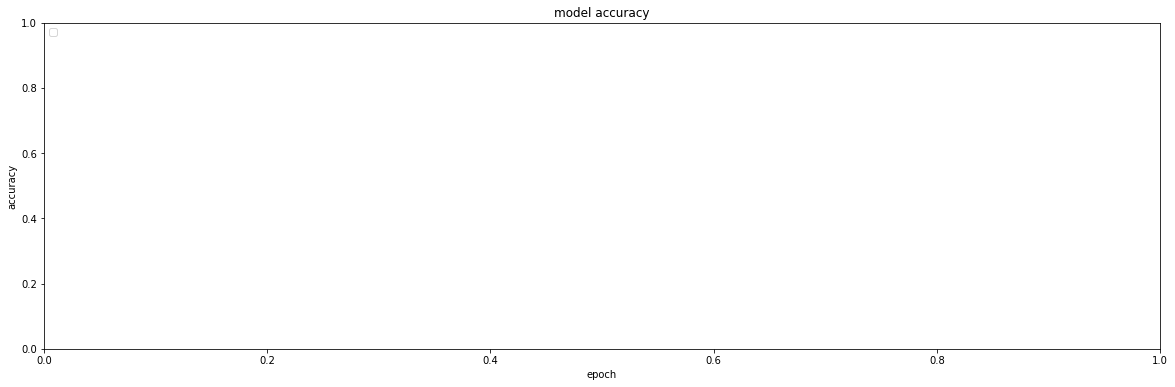

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

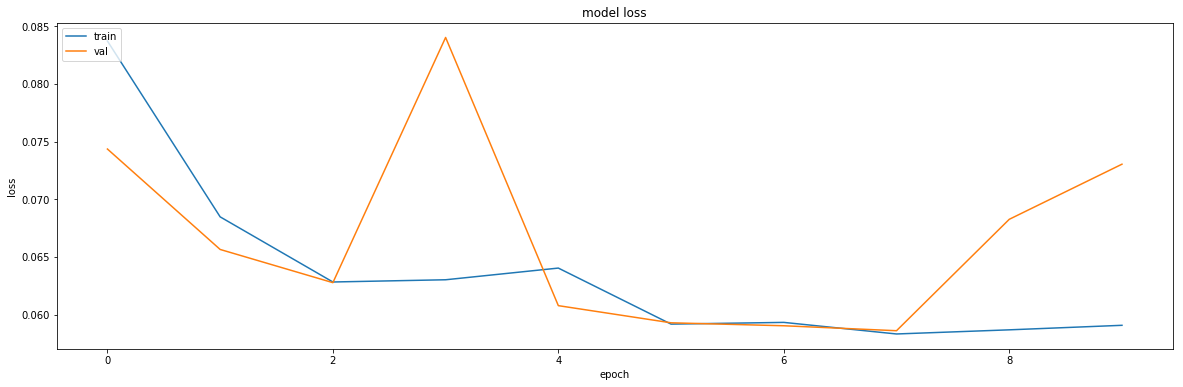

In [103]:
# summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [104]:
'''# Returns a compiled model identical to the previous one
model = load_model('E:\Data Science\Personal_Project\RNN - Solar Farm\model\LSTM_Model.h5')

y_predict = model.predict(x_test_reshaped, verbose)'''

"# Returns a compiled model identical to the previous one\nmodel = load_model('E:\\Data Science\\Personal_Project\\RNN - Solar Farm\\model\\LSTM_Model.h5')\n\ny_predict = model.predict(x_test_reshaped, verbose)"

In [105]:
history.history['loss']

[0.08371705610602434,
 0.06847052604639028,
 0.06282376595314088,
 0.06301655917761366,
 0.06402963730711914,
 0.05917074704911255,
 0.05932053983812351,
 0.058316055211453645,
 0.05867508954144593,
 0.0590677565432947]

In [106]:
y_predict = model_RNN.predict(x_test_reshaped, verbose)
y_predict = y_predict.reshape(y_predict.shape[0],)

In [107]:
comparison = pd.DataFrame(data=np.column_stack((y_test,y_predict)),columns=['actual','prediction'])
comparison = comparison.set_index(test.index[n_steps-1:])

In [119]:
denormalizing_data = main_data.copy()
denormalizing_data.drop(columns = ['total_points'], inplace = True)
denormalizing_data['prediction'] = comparison['prediction']
denormalizing_data.dropna(axis=0,inplace=True)
denormalized_prediction = pd.DataFrame(scaler.inverse_transform(denormalizing_data), index=test.index[n_steps-1:], columns=denormalizing_data.columns)['prediction']

denormalizing_actual = main_data.copy()
denormalizing_actual.drop(columns = ['total_points'], inplace = True)
denormalizing_actual['actual'] = comparison['actual']
denormalizing_actual.dropna(axis=0,inplace=True)
denormalized_actual = pd.DataFrame(scaler.inverse_transform(denormalizing_actual), index=test.index[n_steps-1:], columns=denormalizing_actual.columns)['actual']

comparison = pd.concat([denormalized_actual, denormalized_prediction], axis=1)

In [120]:
comparison

,,actual,prediction
id,fixture,,
171,36,1.0,0.138193
152,62,1.0,0.718657
534,168,1.0,2.232332
225,41,1.0,2.265958
433,230,1.0,2.274250
195,254,1.0,2.194555
72,8,1.0,2.280887
73,263,1.0,2.246091
330,286,1.0,2.237457


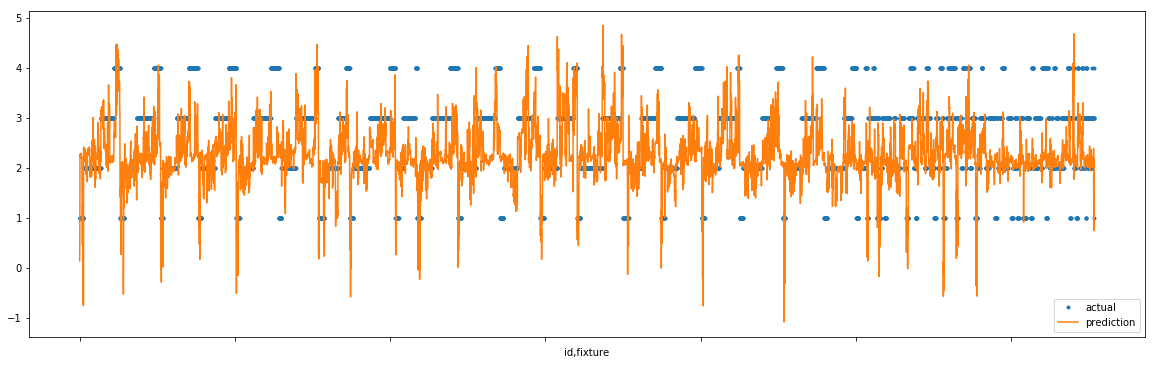

In [121]:
comparison.plot(style=['.','-'])

In [122]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
new_df = comparison
mse = mean_squared_error(new_df['actual'], new_df['prediction'])
mape = mean_absolute_percentage_error(new_df['actual'], new_df['prediction'])
mae = mean_absolute_error(new_df['actual'], new_df['prediction'])

#mean 

print(f'\nRMSE: {math.sqrt(mse)}\nMAE: {mae}')  


RMSE: 47.89844692915446
MAE: 20.703022823489544


D:\Programming\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [81]:
# Saving the result
comparison.to_csv(mypath + 'Result\\CNN_' + str(round((mae), 4)) + '.csv', index = True)

In [82]:
# Creates a HDF5 file 'my_model.h5'
model_RNN.save(mypath + 'Model\\CNN_' + str(round((mae), 4))  + '.h5')

# Deletes the existing model
# del model  


# For Improvements: